In [8]:
import os
import cv2
import copy
import time
import random
import pickle

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

In [5]:
class CFG:
    model_name = 'tf_efficientnet_b4_ns'
    img_size = 512
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    T_0 = 10
    lr = 1e-5
    min_lr = 1e-7
    batch_size = 20
    weight_decay = 1e-6
    seed = 42
    num_classes = 5
    num_epochs = 3
    n_fold = 5
    smoothing = 0.2
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
    
    # THIS IS SOMETHING NEW. We will see where this is used later
    Binsize = 100

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CFG.seed)

In [ ]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")

skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label)):
    df.loc[val_ , "kfold"] = int(fold)
    
df['kfold'] = df['kfold'].astype(int)

class CassavaLeafDataset(nn.Module):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.df.iloc[index, 0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[index, 1]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, label

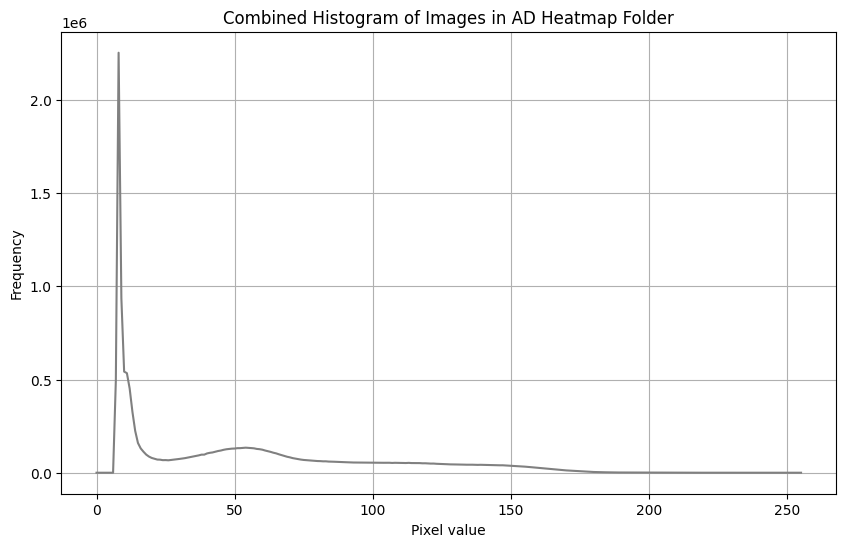

In [14]:
def plot_histogram(folder_path):
    # List to store histograms
    histograms = []

    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("L")  # Convert image to grayscale
            histogram = np.array(image.histogram())
            histograms.append(histogram)

    # Combine histograms
    combined_histogram = np.sum(histograms, axis=0)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.plot(combined_histogram, color='gray')
    plt.title("Combined Histogram of Images in AD Heatmap Folder")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example usage
folder_path = 'data/GMM_data/resnet_coronal/AD'
plot_histogram(folder_path)

# Anomaly Detection

## Import

In [15]:
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [59]:
for i in os.listdir(val_path):
    print(i)
    class_folder = os.path.join(val_path,i)
    for j in os.listdir(class_folder):
        old_name = os.path.join(class_folder, j)
        new_name = os.path.join(class_folder, i+'_'+j)
        os.rename(old_name, new_name)
print('done')

NC
AD
MCI
done


In [16]:

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
image_path = 'data/AnomalyDetection/Coronal/train/AD'
names = ['heat_y-97', 'heat_y-98', 'heat_y-102']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]

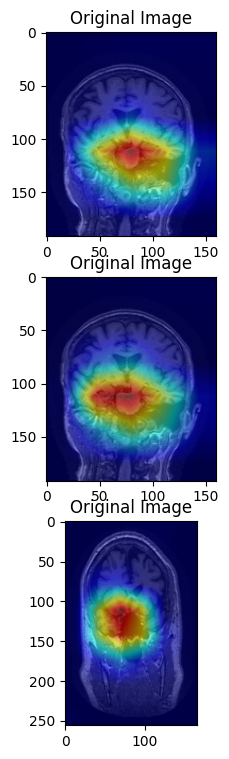

In [20]:

fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

plt.show()

In [32]:
for i in os.listdir(train_path):
    print(i)

NC
AD
MCI


In [21]:
class HeatmapDataset(Dataset):
    def __init__(self, image_path, num_classes=3, transform=None):
        self.image_path = image_path
        self.num_classes = num_classes
        self.transform = transform
        image_list = glob.glob(image_path + '/*.png')
        sample_names = [file.split('/')[-1].split('.')[0] for file in image_list]
        self.sample_names = sample_names
        # self.transforms = T.Compose([T.ToTensor()],
        #                             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #                            )

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_path, self.sample_names[idx] + '.png'))
        image = image.convert('RGB')
        
        image = self.transforms(image)
        resized_image = T.Resize((104, 104))(image)
        
        return resized_image

    def __len__(self):
        return len(self.sample_names)

In [33]:
standard_size = (64,64)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(standard_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # lambda x: torch.flatten(x)
])

# train_path = 'data/AnomalyDetection/Coronal/train'
# val_path = 'data/AnomalyDetection/Coronal/val'
# test_path = 'data/AnomalyDetection/Coronal/test'
                                 
# train_data = HeatmapDataset(train_path, transform=data_transform)
# val_data = HeatmapDataset(val_path, transform=data_transform)
# test_data = HeatmapDataset(test_path, transform=data_transform)

In [24]:
BATCH_SIZE = 64
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
image = Image.open('data/AnomalyDetection/Coronal/train/AD/heat_y-103.png')
rgb_image = image.convert('RGB')
print(np.asarray(rgb_image).shape)

(192, 160, 3)


In [65]:
train_data = datasets.ImageFolder(root='data/AnomalyDetection/Coronal/train', transform=data_transform)
val_data = datasets.ImageFolder(root='data/AnomalyDetection/Coronal/val', transform=data_transform)
test_data = datasets.ImageFolder(root='data/AnomalyDetection/Coronal/test', transform=data_transform)

# 數據加載器
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# anomaly_data = datasets.ImageFolder(root='data/AnomalyDetection/Coronal/anomaly', transform=data_transform)
# anomaly_loader = torch.utils.data.DataLoader(anomaly_data, batch_size=32, shuffle=False)


In [66]:
image, label = train_data[15]
print(image.shape)
print(label)


torch.Size([3, 64, 64])
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

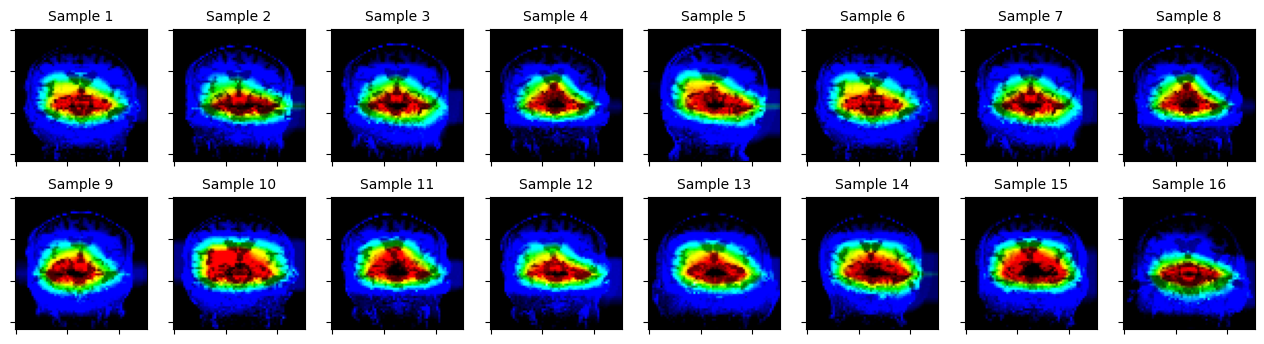

In [67]:
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, label = train_data[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [77]:
encoder = models.resnet18(pretrained=True)
encoder.fc = nn.Identity()  # Remove the final fully connected layer

# Define the Decoder
decoder = nn.Sequential(
    nn.Linear(512, 1024),    # Linear layer to increase dimensionality
    nn.ReLU(),
    nn.Linear(1024, 2048),   # Linear layer to further increase dimensionality
    nn.ReLU(),
    nn.Linear(2048, 64),  # Output layer to match image dimensions
    nn.Tanh()                # Tanh activation for pixel values in the range [-1, 1]
)

In [78]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the Autoencoder
autoencoder = Autoencoder(encoder, decoder)

In [13]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # resnet18 = models.resnet18(pretrained=True)
        # Extract features from ResNet18
        self.encoder = nn.Sequential(
            nn.Linear(16, 3072),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
            # *list(resnet18.children())[:-1]
        )
        
        self.decoder = nn.Sequential(  
                # nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                # nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                # nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                # nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
                # nn.Sigmoid()
                nn.Linear(16, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 784),
                nn.ReLU()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        # x = self.flatten(x)
        x = self.decoder(x)
        return x

# Instantiate the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Autoencoder().to(device)

criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = autoencoder.to(device)
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [64]:
# Train the model
num_epochs = 10
losses = []  # List to store the losses for each epoch
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        recon = model(img)
        print(recon.shape)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss for the epoch
    losses.append(epoch_loss)  # Store the epoch loss
print("Training step is done")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [114]:
# # Training the autoencoder
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, _ in train_loader:
#         images = images.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, images)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     # Print average loss at the end of each epoch
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 1.9111
Epoch [2/10], Loss: 1.9113
Epoch [3/10], Loss: 1.9113
Epoch [4/10], Loss: 1.9112
Epoch [5/10], Loss: 1.9113
Epoch [6/10], Loss: 1.9113
Epoch [7/10], Loss: 1.9113
Epoch [8/10], Loss: 1.9113
Epoch [9/10], Loss: 1.9113
Epoch [10/10], Loss: 1.9113


In [86]:
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # labels = labels.float()
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, images)
        
        labels = labels.float()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")


/home/user/miniconda3/envs/open-mmlab/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64, 3, 64, 64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (62) at non-singleton dimension 1

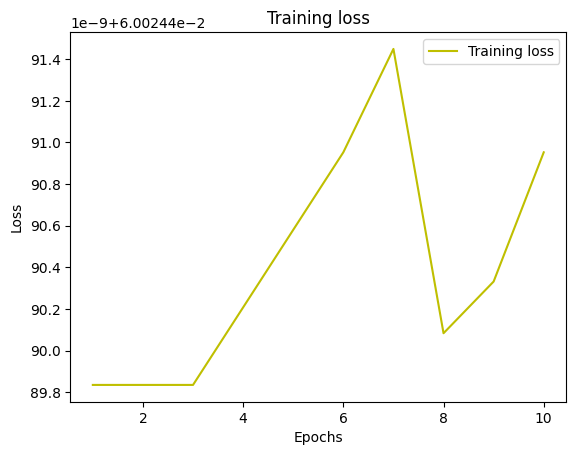

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


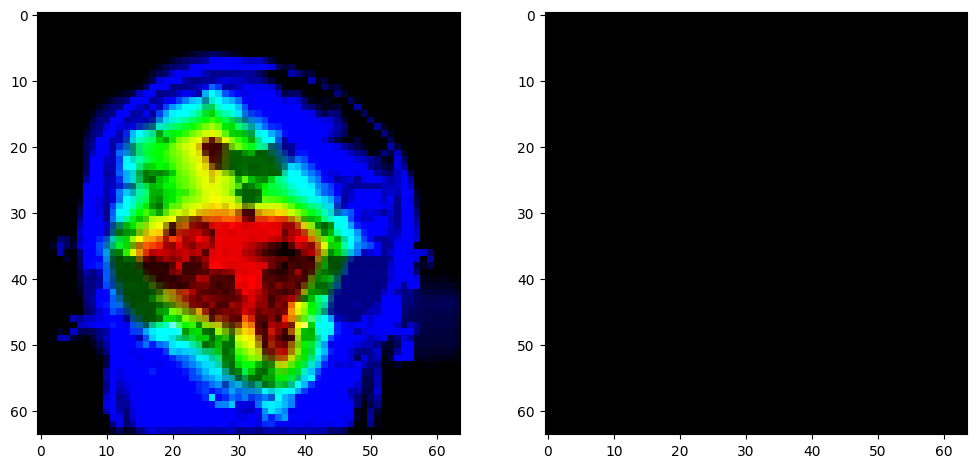

In [54]:
# Plot training and validation loss
# (Note: PyTorch does not automatically record validation loss during training)
# You can calculate validation loss separately if needed.
plt.plot(range(1, num_epochs + 1), losses, 'y', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Get a batch of images for prediction
data_batch = next(iter(train_loader))[0]
predicted = model(data_batch)

# Visualize original and reconstructed images
image_number = random.randint(0, len(data_batch) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[image_number].permute(1, 2, 0))
plt.subplot(122)
plt.imshow(predicted[image_number].detach().permute(1, 2, 0))
plt.show()

In [ ]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(
#             in_channels = in_channels,
#             out_channels = out_channels,
#             kernel_size = kernel_size,
#             stride=stride,
#             padding=padding
#         )

#         self.batch_norm = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.batch_norm(x)
#         return self.relu(x)

In [42]:
class SimpleCNN(nn.Module):
    def __init__(self,in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = kernel_size,
            stride=stride,
            padding=padding
                              )
        self.pool = nn.MaxPool2d(2,2)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return self.fc2(x)
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        # print("Conv2d output shape:", x.shape)
        # # x = x.view(x.size(0), -1)
        # # x = F.relu(self.fc1(x))
        # x = F.relu(x)
        
        # # x = self.fc2(x)
        # return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 訓練模型
for epoch in range(10):  # 迭代次數
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x32 and 128x3)

# Tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check if TensorFlow is using GPU
print("TensorFlow GPU Device: ", tf.test.gpu_device_name())

Num GPUs Available:  1
TensorFlow GPU Device:  /device:GPU:0


2024-02-26 16:08:35.407265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 16:08:35.787670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 16:08:35.787815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#Size of our input images
SIZE = 128

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'data/AnomalyDetection/Coronal/train',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'data/AnomalyDetection/Coronal/val',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )
# anomaly_generator = datagen.flow_from_directory(
#     'cell_images2/parasitized/',
#     target_size=(SIZE, SIZE),
#     batch_size=batch_size,
#     class_mode='input'
#     )

Found 960 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [6]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 16)       

2024-02-26 16:54:37.554077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:435] Loaded runtime CuDNN library: 8.2.4 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-02-26 16:54:37.554655: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node sequential_1/conv2d_7/Relu defined at (most recent call last):
  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_327771/3136112351.py", line 24, in <module>

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/user/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu

DNN library is not found.
	 [[{{node sequential_1/conv2d_7/Relu}}]] [Op:__inference_train_function_3613]